# MVP Engenharia de Dados

In [0]:
import pandas as pd
from pyspark.sql.functions import explode,col,from_json
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType

# 0. Objetivos

Entender a distribuição dos atores na base de filmes:
- Qual o filme com mais atores da base?
- Que porcentagem dos atores são mulheres?
- Que ator e atriz mais atuaram em filmes?
- Como a presença de mulheres tem variado ao longo do tempo?

Entender características relacionadas aos filmes:
- Qual gênero de filme é mais comum?
- Que país faz mais filmes desse gênero?

# 1. Busca pelos dados

 Os dados foram extraídos do Kaggle do dataset [The Movie Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/code), que agrega metadata de mais de 45.000 filmes.

# 2. Coleta

Uma vez baixados do Kaggle, os dados foram armazenados em pastas no github, de forma fracionada para respeitar o limite de tamanho imposto pela plataforma, de forma que podem ser importados nestem notebook de forma simples.

# 3. Modelagem

O modelo de dados escolhido foi o de estrela com várias tabelas fato e dimensões que interconectam. Os dados foram obtidos a partir de um dataset do Kaggle, que por sua vez foi obtido por meio da TMDB Open API e também pelo GroupLens

## 3.1. Catálogo de Dados

### **Tabelas dimensão**
1. **dim_actors**: Dimensão com atores e atrizes que participaram em algum filme da base dados.
- actor_id : Chave primária, número inteiro, identifica unicamente os atores
- actor_gender : Número inteiro, identifca o ator em 2 para masculino, 1 para feminino ou 0 para indeterminado.

2. **dim_genres**: Dimensão com gêneros de filmes da base.
- genre_id : Chave primária, número inteiro, identifica unicamente os gêneros de filmes
- genre_name : String, nome do gênero de filme.

3. **dim_production_countries**: Dimensão de países produtores de filmes.
- country_id : Chave primária, String de 2 caracteres, identifica unicamente os países produtores de filmes
- country_name : String, nome do país produtor do filmes.

4. **dim_movies**: Dimensão de filmes.
- id : Chave primária, número inteiro, identifica unicamente os filmes.
- title : String, Título do filme.
- adult : Booleano, indica se o filme é adulto ou não.
- budget : Número inteiro, orçamento do filme.
- revenue : Double, total faturado com o filme.
- belongs_to_collection : String, se o filme pertence a alguma coleção de filmes.
- popularity : string
- release_date : string
- status: string, se o filme já foi lançado (Released), se é apenas um rumor (Rumored), se está em pós prdução (Post Production.)
- vote_average : double, média dos votos dados ao filme, numa pontuação de 1 a 5.
- vote_count : Número inteiro, contagem do número de votos em dado filme.

### **Tabelas Fato**

1. **fat_movie_cast**: Tabela fato com atores e filmes de que participaram.
- actor_id : Chave Estrangeira, número inteiro, identifica unicamente os atores
- movie_id : Chave Estrangeira, número inteiro, identifca o filme.

2. **fat_movie_genres**: Tabela fato com filmes e gêneros atribuídos a eles.
- genre_id : Chave Estrangeira, número inteiro, identifica o gênero do filme.
- movie_id : Chave Estrangeira, número inteiro, identifca o filme.

3. **fat_movie_production_countries**: Tabela fato com filmes e países que estiveram envolvidos em sua produção.
- country_id : Chave Estrangeira, número inteiro, identifica país envolvido na produção do filme.
- movie_id : Chave Estrangeira, número inteiro, identifca o filme.

Camada bronze

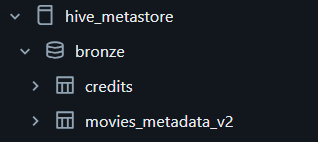

Camada prata

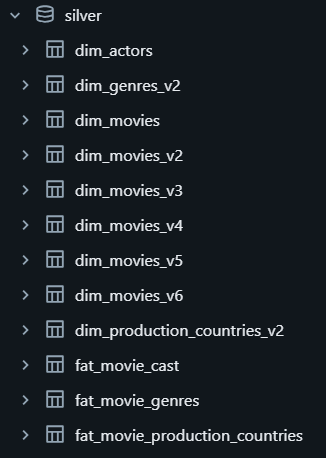

Camada Ouro

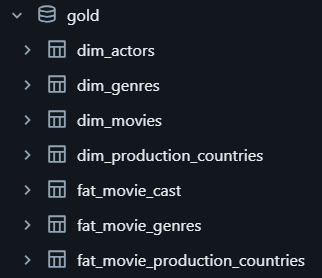

# 4. Carga

## 4.1 Extração

In [0]:
credits_df = pd.DataFrame({})
for i in range(16):
  url = f"https://raw.githubusercontent.com/vinicius-souza-lima/mvp_data_engineering/refs/heads/master/dataset/credits/credits_{i+1}.csv"
  credits_df = pd.concat([credits_df,pd.read_csv(url)])

In [0]:
movies_metadata_df = pd.DataFrame({})
for i in range(2):
  url = f"https://raw.githubusercontent.com/vinicius-souza-lima/mvp_data_engineering/refs/heads/master/dataset/movies_metadata/movies_metadata_{i+1}.csv"
  movies_metadata_df = pd.concat([movies_metadata_df,pd.read_csv(url)])

In [0]:
%sql CREATE DATABASE IF NOT EXISTS bronze;

In [0]:
credits_spark_df = spark.createDataFrame(credits_df)
credits_spark_df.write.mode("overwrite").saveAsTable("bronze.credits")

In [0]:
movies_metadata_df["video"] = movies_metadata_df["video"].astype(str)
movies_metadata_spark_df = spark.createDataFrame(movies_metadata_df)
movies_metadata_spark_df.write.mode("overwrite").saveAsTable("bronze.movies_metadata_v2")

/databricks/spark/python/pyspark/sql/pandas/conversion.py:467: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Could not convert '0.785591' with type str: tried to convert to double
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


## 4.2 Transformação e carregamento

In [0]:
%sql CREATE DATABASE IF NOT EXISTS silver

In [0]:
# Define o schema da lista de gêneros
genre_schema = ArrayType(
    StructType([
        StructField("id", IntegerType(), True),
        StructField("name", StringType(), True)
    ])
)

# Converte a string JSON para um array de structs
movies_metadata_spark_df = movies_metadata_spark_df.withColumn("genres", from_json(col("genres"), genre_schema))
movies_with_genre_spark_df = movies_metadata_spark_df.withColumn("genres",explode(col("genres")))

In [0]:
dim_genres_spark_df = movies_with_genre_spark_df.select(
    col("genres.id").cast("bigint").alias("genre_id"),
    col("genres.name").cast("bigint").alias("genre_name")
).distinct()

In [0]:
dim_genres_spark_df.write.mode("overwrite").saveAsTable("silver.dim_genres_v2")

In [0]:
fat_movie_genres = movies_with_genre_spark_df.select(
    col("id").cast("bigint").alias("movie_id"),
    col("genres.id").cast("bigint").alias("genre_id")
)

In [0]:
fat_movie_genres.write.mode("overwrite").saveAsTable("silver.fat_movie_genres")

In [0]:
# Define o schema da lista de gêneros
production_countries_schema = ArrayType(
    StructType([
        StructField("iso_3166_1", StringType(), True),
        StructField("name", StringType(), True)
    ])
)

# Converte a string JSON para um array de structs
movies_metadata_spark_df = movies_metadata_spark_df.withColumn("production_countries", from_json(col("production_countries"), production_countries_schema))
movies_with_production_countries_df = movies_metadata_spark_df.withColumn("production_countries",explode(col("production_countries")))

In [0]:
dim_production_countries = movies_with_production_countries_df.select(
    col("production_countries.iso_3166_1").alias("country_id"),
    col("production_countries.name").alias("country_name")
).distinct()

In [0]:
dim_production_countries.write.mode("overwrite").saveAsTable("silver.dim_production_countries_v2")

In [0]:
fat_movie_production_countries = movies_with_production_countries_df.select(
    col("id").cast("bigint").alias("movie_id"),
    col("production_countries.iso_3166_1").alias("country_id")
)

In [0]:
fat_movie_production_countries.write.mode("overwrite").saveAsTable("silver.fat_movie_production_countries")

In [0]:
# Define o schema da lista de gêneros
cast_schema = ArrayType(
    StructType([
    StructField("cast_id", IntegerType(), True),
    StructField("character", StringType(), True),
    StructField("credit_id", StringType(), True),
    StructField("gender", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("order", IntegerType(), True),
    StructField("profile_path", StringType(), True)
])
)

# Converte a string JSON para um array de structs
credits_spark_df = credits_spark_df.withColumn("cast", from_json(col("cast"), cast_schema))
credits_spark_with_cast_df = credits_spark_df.withColumn("cast",explode(col("cast")))

In [0]:
dim_actors = credits_spark_with_cast_df.select(
    col("cast.id").alias("actor_id"),
    col("cast.gender").alias("actor_gender"),
    col("cast.name").alias("name")
).distinct()

In [0]:
dim_actors.write.mode("overwrite").saveAsTable("silver.dim_actors")

In [0]:
fat_movie_cast = credits_spark_with_cast_df.select(
    col("id").alias("movie_id"),
    col("cast.id").alias("actor_id")
)

In [0]:
fat_movie_cast.write.mode("overwrite").saveAsTable("silver.fat_movie_cast")

In [0]:
movies_metadata_spark_df = movies_metadata_spark_df.drop("genres","production_companies","production_countries","homepage","poster_path","original_language","spoken_languages","imdb_id","overview","tagline","runtime","video","budget","revenue","popularity","original_title","belongs_to_collection")


In [0]:
movies_metadata_spark_df.write.format("delta").mode("overwrite").saveAsTable("silver.dim_movies_v6")

# 5. Análise

## 5.1. Qualidade dos Dados

In [0]:
%sql SELECT * FROM silver.dim_actors LIMIT 10

actor_id,actor_gender,name
17770,2,Kevin Tighe
925,2,Paul Guilfoyle
658,2,Alfred Molina
305332,2,Masumi Okada
3905,2,William H. Macy
19728,2,Mark Harmon
1218048,2,Randle Mell
693,0,Roshan Seth
4093,2,Ray Walston
13992,1,Mary Astor


In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  COUNT(CASE WHEN actor_id IS NULL THEN 1 END) AS column1_null_count,
  COUNT(CASE WHEN actor_gender IS NULL THEN 1 END) AS column2_null_count,
  COUNT(CASE WHEN name IS NULL THEN 1 END) AS column3_null_count
  -- Adicione mais colunas conforme necessário
FROM silver.dim_actors

total_rows,column1_null_count,column2_null_count,column3_null_count
38856,0,0,0


Da query acima encontramos que não existem valores nulos na tabela. No entanto, analisando as porcentagens, percebe-se que parte significativa é de indeterminados, que devem ser desconsiderados na análise.

In [0]:
%sql 
SELECT actor_gender,
COUNT(*) AS frequencia,
ROUND(COUNT(*)*100/(SELECT COUNT(*) FROM silver.dim_actors),2) AS porcentagem
FROM silver.dim_actors
GROUP BY actor_gender
ORDER BY frequencia DESC

actor_gender,frequencia,porcentagem
2,15562,40.05
0,13264,34.14
1,10030,25.81


In [0]:
%sql 
SELECT * 
FROM silver.dim_actors
WHERE actor_gender = 0
LIMIT 10

actor_id,actor_gender,name
693,0,Roshan Seth
1072036,0,Sydni Beaudoin
89728,0,Cliff Clark
1573198,0,Cori Wellins
122546,0,Al Palagonia
84598,0,Robert Hy Gorman
94942,0,Charles Granval
8480,0,Tamara Ogorodnikova
1083422,0,Malcolm 'Bud' McTaggart
57392,0,Michael Chambers


Por exemplo Rashan Seth era homem, Sydni Beaudoin era mulher, Charles Granval era homem

In [0]:
%sql 
SELECT * 
FROM silver.dim_actors
WHERE actor_gender = 1
LIMIT 10

actor_id,actor_gender,name
13992,1,Mary Astor
153254,1,Vivian Vance
170146,1,Kim Flowers
2229,1,Catherine Keener
1060422,1,Lily Allen
28933,1,Jean Stapleton
34407,1,Rusty Schwimmer
96408,1,Rosemary Leach
30978,1,Charlotte Austin
47080,1,Gloria Talbott


In [0]:
%sql 
SELECT * 
FROM silver.dim_actors
WHERE actor_gender = 2
LIMIT 10

actor_id,actor_gender,name
17770,2,Kevin Tighe
925,2,Paul Guilfoyle
658,2,Alfred Molina
305332,2,Masumi Okada
3905,2,William H. Macy
19728,2,Mark Harmon
1218048,2,Randle Mell
4093,2,Ray Walston
34715,2,James Nesbitt
92565,2,Larry Flynt


In [0]:
%sql SELECT * FROM silver.dim_genres_v2
ORDER BY genre_id
LIMIT 10

genre_id,genre_name
12,Adventure
14,Fantasy
16,Animation
18,Drama
27,Horror
28,Action
35,Comedy
36,History
37,Western
53,Thriller


In [0]:
%sql
SELECT
  COUNT(*) AS total_rows,
  COUNT(CASE WHEN genre_id IS NULL THEN 1 END) AS id_null_count,
  COUNT(CASE WHEN genre_name IS NULL THEN 1 END) AS name_null_count
  -- Adicione mais colunas conforme necessário
FROM silver.dim_genres_v2

total_rows,id_null_count,name_null_count
32,0,0


In [0]:
%sql SELECT * FROM silver.dim_movies_v6
ORDER BY id
LIMIT 10

adult,id,release_date,status,title,vote_average,vote_count
False,100,1998-03-05,Released,"Lock, Stock and Two Smoking Barrels",7.5,1671.0
False,10000,1993-12-25,Released,La estrategia del caracol,7.2,9.0
False,10001,1988-12-15,Released,Young Einstein,4.5,46.0
False,100010,1940-12-27,Released,Flight Command,6.0,1.0
False,100017,2006-08-06,Released,Hounded,4.8,7.0
False,10002,1986-06-13,Released,Mona Lisa,6.7,62.0
False,100024,2012-05-10,Released,Bloodwork,4.3,13.0
False,10003,1997-04-03,Released,The Saint,5.9,310.0
False,100032,1990-11-11,Released,The Great Los Angeles Earthquake,6.8,5.0
False,100033,1936-02-27,Released,Mr. Thank You,6.9,7.0


É necessário converter a coluna adult para booleano

In [0]:
%sql SELECT DISTINCT adult FROM silver.dim_movies_v6

adult
False
Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.
True
- Written by Ørnås
Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.


In [0]:
%sql

ALTER TABLE silver.dim_movies_v6
SET TBLPROPERTIES (
  'delta.columnMapping.mode' = 'name',
  'delta.minReaderVersion' = '2',
  'delta.minWriterVersion' = '5'
);

In [0]:
%sql
-- Crie nova coluna com conversão booleana
ALTER TABLE silver.dim_movies_v6 ADD COLUMNS (adult_bool BOOLEAN);


In [0]:
%sql
UPDATE silver.dim_movies_v6
SET adult_bool = 
  CASE 
    WHEN adult = 'True' THEN true
    WHEN adult = 'False' THEN false
    ELSE null
  END;

num_affected_rows
45466


In [0]:
%sql
-- Remova a original e renomeie
ALTER TABLE silver.dim_movies_v6 DROP COLUMN adult;
ALTER TABLE silver.dim_movies_v6 RENAME COLUMN adult_bool TO adult;

In [0]:
%sql
ALTER TABLE silver.dim_movies_v6 ADD COLUMNS (id_num BIGINT);

UPDATE silver.dim_movies_v6
SET id_num = TRY_CAST(id as BIGINT)

num_affected_rows
45466


In [0]:
%sql
-- Remova a original e renomeie
ALTER TABLE silver.dim_movies_v6 DROP COLUMN id;
ALTER TABLE silver.dim_movies_v6 RENAME COLUMN id_num TO id;

In [0]:
%sql
-- Cria uma nova coluna com o valor convertido
ALTER TABLE silver.dim_movies_v6 ADD COLUMNS (release_date_converted DATE);

UPDATE silver.dim_movies_v6
SET release_date_converted = TO_DATE(release_date,'yyyy-MM-dd');


num_affected_rows
45466


In [0]:
%sql
-- Remova a original e renomeie
ALTER TABLE silver.dim_movies_v6 DROP COLUMN release_date;
ALTER TABLE silver.dim_movies_v6 RENAME COLUMN release_date_converted TO release_date;

In [0]:
%sql SELECT * FROM silver.dim_movies_v6
ORDER BY id
LIMIT 10

status,title,vote_average,vote_count,adult,id,release_date
NaN,NaN,NaN,NaN,null,null,null
NaN,NaN,NaN,NaN,null,null,null
NaN,NaN,NaN,NaN,null,null,null
Released,Ariel,7.1,44.0,false,2,1988-10-21
Released,Shadows in Paradise,7.1,35.0,false,3,1986-10-16
Released,Four Rooms,6.5,539.0,false,5,1995-12-09
Released,Judgment Night,6.4,79.0,false,6,1993-10-15
Released,Star Wars,8.1,6778.0,false,11,1977-05-25
Released,Finding Nemo,7.6,6292.0,false,12,2003-05-30
Released,Forrest Gump,8.2,8147.0,false,13,1994-07-06


In [0]:
%sql
DELETE FROM silver.dim_movies_v6
WHERE id IS NULL;

num_affected_rows
3


## 5.2. Solução do Problema

In [0]:
%sql CREATE DATABASE IF NOT EXISTS gold

In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_actors
USING DELTA
AS
SELECT * FROM silver.dim_actors;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_movies
USING DELTA
AS
SELECT * FROM silver.dim_movies_v6;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_movies
USING DELTA
AS
SELECT * FROM silver.dim_movies_v6;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_genres
USING DELTA
AS
SELECT * FROM silver.dim_genres_v2;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.dim_production_countries
USING DELTA
AS
SELECT * FROM silver.dim_production_countries_v2;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.fat_movie_cast
USING DELTA
AS
SELECT * FROM silver.fat_movie_cast;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.fat_movie_genres
USING DELTA
AS
SELECT * FROM silver.fat_movie_genres;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.fat_movie_production_countries
USING DELTA
AS
SELECT * FROM silver.fat_movie_production_countries;

num_affected_rows,num_inserted_rows


In [0]:
%sql
CREATE OR REPLACE TABLE gold.fat_movie_genres
USING DELTA
AS
SELECT * FROM silver.fat_movie_genres;

num_affected_rows,num_inserted_rows


Qual o filme com mais atores da base?

In [0]:
%sql
SELECT 
  f.movie_id,
  d.title,
  COUNT(DISTINCT f.actor_id) AS total_atores
FROM gold.fat_movie_cast f
JOIN gold.dim_movies d
  ON f.movie_id = d.id
GROUP BY f.movie_id, d.title
ORDER BY total_atores DESC
LIMIT 1;

movie_id,title,total_atores
209112,Batman v Superman: Dawn of Justice,152


Evidência

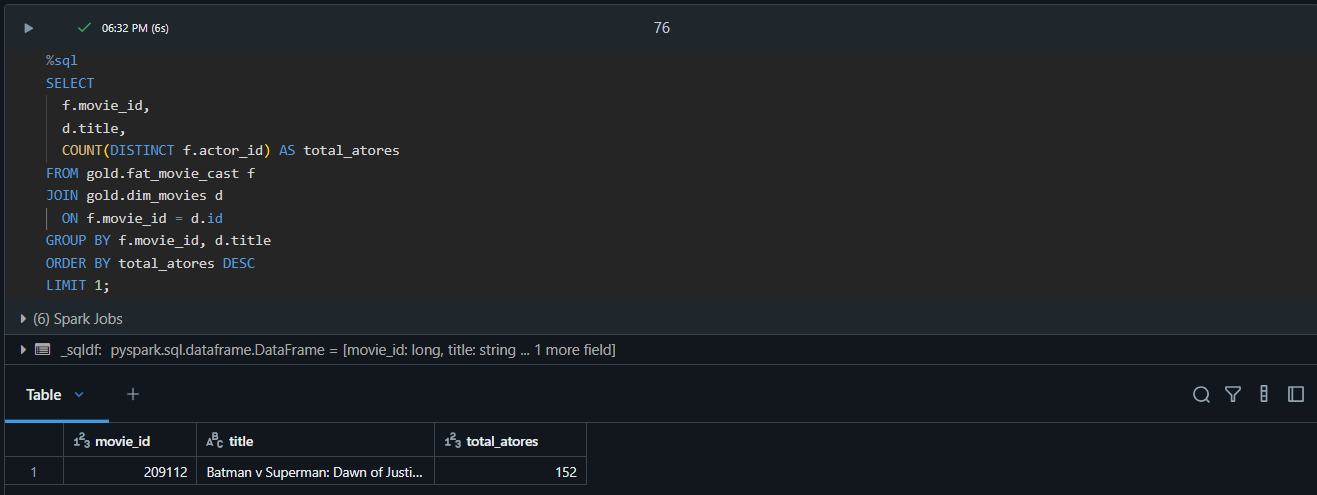

Batman VS Superman é o filme com mais atores da base, com 152 atores

Que porcentagem dos atores são mulheres?

In [0]:
%sql
SELECT 
  ROUND(
    COUNT(CASE WHEN actor_gender = 1 THEN 1 END) * 100.0 / COUNT(*), 
    2
  ) AS percentual_mulheres
FROM gold.dim_actors;

percentual_mulheres
25.81


Evidência

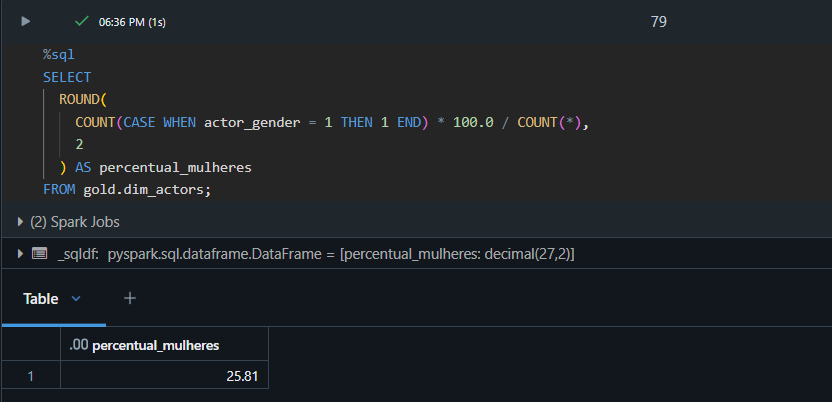

Extensão: E desconsiderando os indefinidos?

In [0]:
%sql
SELECT 
  ROUND(
    COUNT(CASE WHEN actor_gender = 1 THEN 1 END) * 100.0 / COUNT(CASE WHEN actor_gender IN (1, 2) THEN 1 END), 
    2
  ) AS percentual_mulheres
FROM gold.dim_actors;

percentual_mulheres
39.19


Evidência

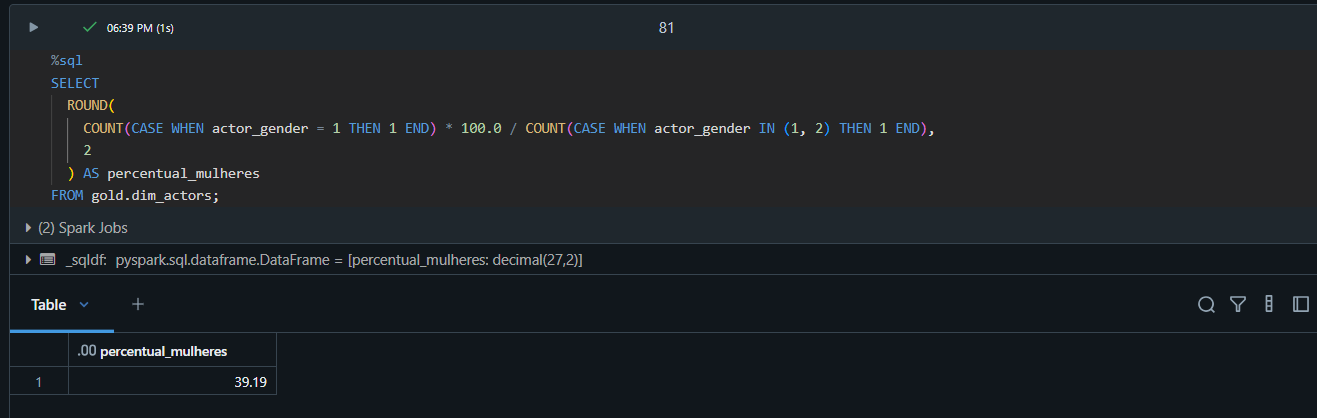

Que ator e atriz mais atuaram em filmes?

In [0]:
%sql
-- Ator que mais atuou (gender = 2)
SELECT a.name, COUNT(*) AS total_filmes
FROM gold.fat_movie_cast f
JOIN gold.dim_actors a ON f.actor_id = a.actor_id
WHERE a.actor_gender = 2
GROUP BY a.name
ORDER BY total_filmes DESC
LIMIT 1;



name,total_filmes
Gérard Depardieu,45


Evidência

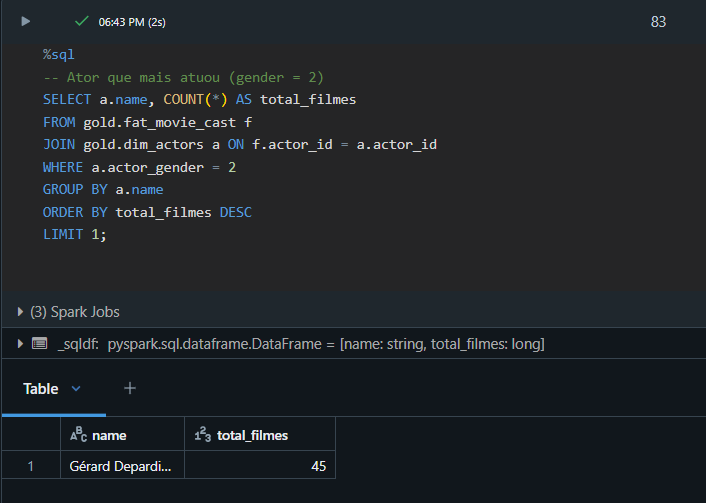

In [0]:
%sql
-- Atriz que mais atuou (gender = 1)
SELECT a.name, COUNT(*) AS total_filmes
FROM gold.fat_movie_cast f
JOIN gold.dim_actors a ON f.actor_id = a.actor_id
WHERE a.actor_gender = 1
GROUP BY a.name
ORDER BY total_filmes DESC
LIMIT 1;

name,total_filmes
Bess Flowers,48


Evidência

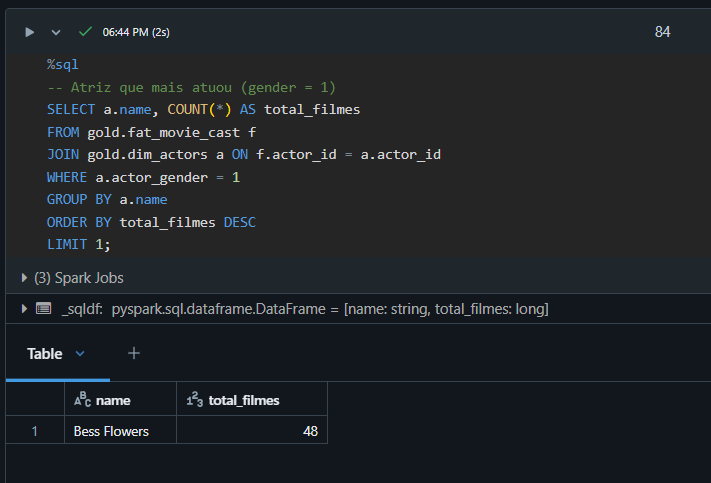

Como a presença de mulheres tem variado ao longo do tempo?

In [0]:
%sql

WITH atores_filmes AS (
  SELECT 
    m.release_date,
    a.actor_gender
  FROM gold.fat_movie_cast f
  JOIN gold.dim_actors a ON f.actor_id = a.actor_id
  JOIN gold.dim_movies m ON f.movie_id = m.id
  WHERE a.actor_gender IN (1, 2) AND m.release_date IS NOT NULL
),
atores_por_ano AS (
  SELECT 
    YEAR(release_date) AS ano,
    COUNT(*) AS total_atores,
    COUNT(CASE WHEN actor_gender = 1 THEN 1 END) AS total_mulheres
  FROM atores_filmes
  GROUP BY YEAR(release_date)
)
SELECT 
  ano,
  total_atores,
  total_mulheres,
  ROUND((total_mulheres * 100.0) / total_atores, 2) AS percentual_mulheres
FROM atores_por_ano
ORDER BY ano;


ano,total_atores,total_mulheres,percentual_mulheres
1909,1,0,0.00
1911,2,1,50.00
1912,5,4,80.00
1913,6,1,16.67
1914,7,2,28.57
1916,2,2,100.00
1917,3,0,0.00
1918,6,3,50.00
1919,3,0,0.00
1920,2,0,0.00


Evidência

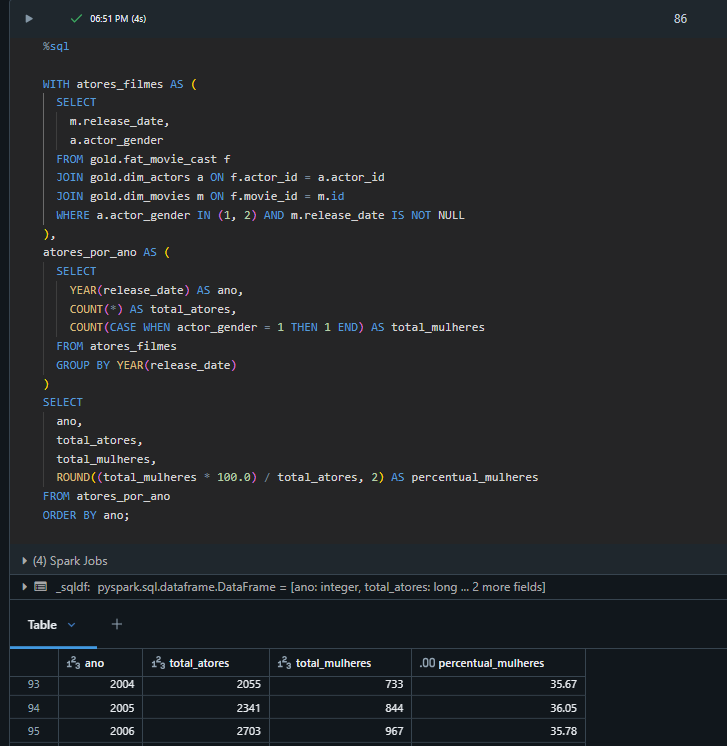

Na maior parte da base a porcentagem de mulheres varia entre cerca de 30 a 40%

Qual gênero de filme é mais comum?

In [0]:
%sql
SELECT 
  g.genre_name,
  COUNT(*) AS total_filmes
FROM gold.fat_movie_genres f
JOIN gold.dim_genres g ON f.genre_id = g.genre_id
GROUP BY g.genre_name
ORDER BY total_filmes DESC
LIMIT 5;


genre_name,total_filmes
Drama,20265
Comedy,13182
Thriller,7624
Romance,6735
Action,6596


Evidência

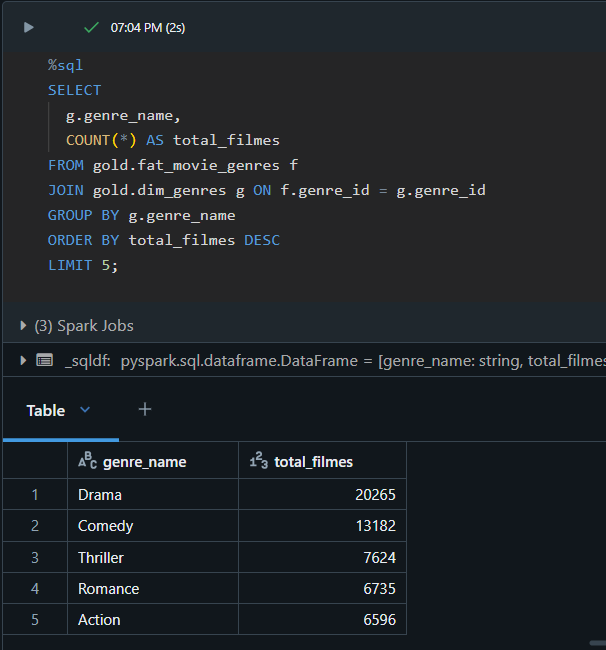

Drama é o gênero de filme mais comum, seguido de comédia, suspense, romance e ação.

Que país faz mais filmes desse gênero?

In [0]:
%sql
SELECT 
  c.country_name,
  COUNT(*) AS total_filmes_drama
FROM gold.fat_movie_genres fmg
JOIN gold.dim_genres g ON fmg.genre_id = g.genre_id
JOIN gold.fat_movie_production_countries fpc ON fmg.movie_id = fpc.movie_id
JOIN gold.dim_production_countries c ON fpc.country_id = c.country_id
WHERE g.genre_name = 'Drama'
GROUP BY c.country_name
ORDER BY total_filmes_drama DESC
LIMIT 5;


country_name,total_filmes_drama
United States of America,9057
France,2425
United Kingdom,2148
Germany,1315
Italy,997


Evidência

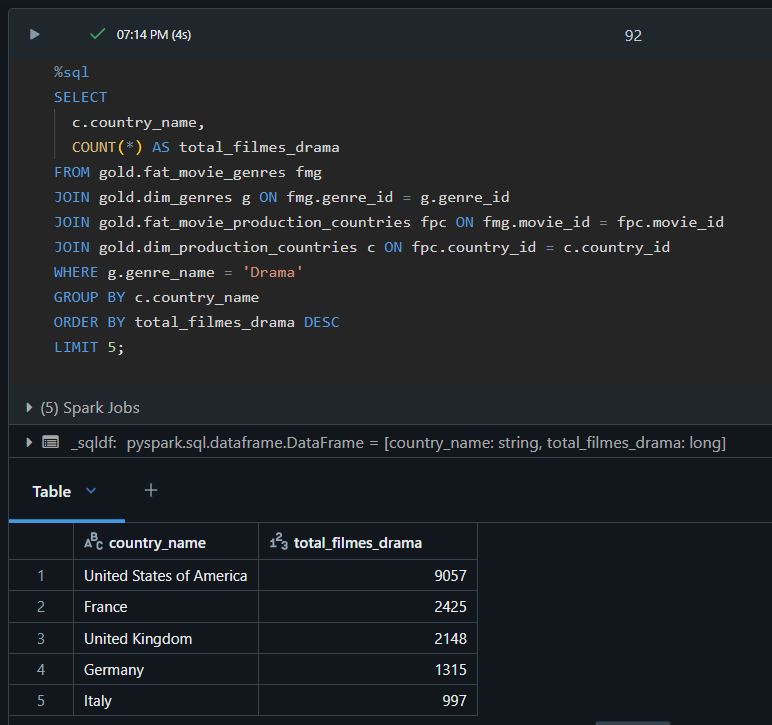

Como esperado Estados Unidos é o país que mais faz filmes de drama, seguido de França e Reino Unido.

# Autoavaliação

Julgo que consegui atingir os obejtivos delineados no início do estudo. Minha maior dificuldade foi entender a sintaxe correta do Spark e como otimizar as quries em SQL para atingir or objetivos desejados. Me desafiei a não utilizar uma tabela flat para agrupar os dados, de forma a construir um data warehouse que exercitasse tudo que aprendi ao longo do curso. Por conta disso, fico muito animado com o projeto que desenvolvi e ansioso para por esse conhecimento em prática.

![](path)